# Анализ данных в задаче кредитного скоринга

Имеются данные о кредитных историях клиентов одного из банков. Поля в предоставляемых данных имеют следующий смысл:

* LIMIT_BAL: размер кредитного лимита (в том числе и на семью клиента)
* SEX: пол клиента (1 = мужской, 2 = женский )
* EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных ).
* MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).
* AGE: возраст в годах
* PAY_0 - PAY_6 : История прошлых платежей по кредиту. PAY_6 - платеж в апреле, ..., PAY_0 - платеж в сентябре. Платеж = (0 = исправный платеж, 1 = задержка в один месяц, 2 = задержка в 2 месяца ...)
* BILL_AMT1 - BILL_AMT6: задолженность, BILL_AMT6 - на апрель, ..., BILL_AMT1 - на сентябрь
* PAY_AMT1 - PAY_AMT6: сумма уплаченная в PAY_AMT6 - апреле, ..., PAY_AMT1 - сентябре
* default - индикатор невозврата денежных средств

In [1]:
from __future__ import division

import numpy as np
import pandas as pd

from scipy import stats
from statsmodels.stats import weightstats as wsm
from statsmodels.stats.proportion import proportion_confint

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
credit_story = pd.read_csv('credit_card_default_analysis.csv')
credit_story.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,...,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,0.356767,0.320033,0.304067,0.258767,...,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,0.760594,0.801727,0.790589,0.761113,...,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,0.000000,0.000000,0.000000,0.000000,...,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,...,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [3]:
pd.set_option('display.max_columns', None)
credit_story.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,0,0,0,0,3913,3102,689,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


### 1. Размер кредитного лимита (LIMIT_BAL).

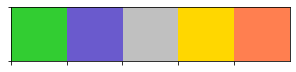

In [4]:
colors = ['limegreen','slateblue','silver','gold','coral']
sns.palplot(sns.color_palette(colors))

In [5]:
lim_bal_money_back = credit_story.LIMIT_BAL[credit_story.default == 0]
lim_bal_money_not_back = credit_story.LIMIT_BAL[credit_story.default == 1]

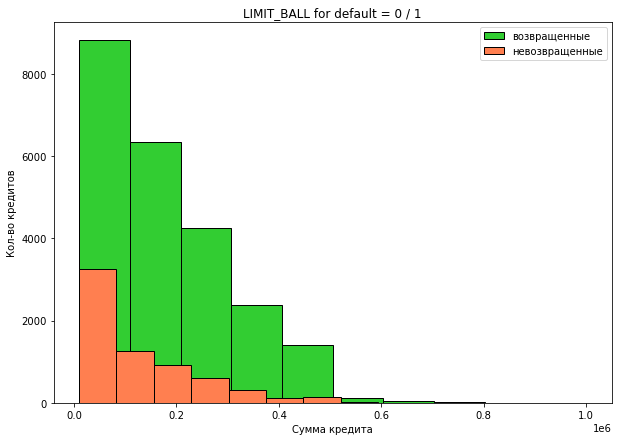

In [7]:
# histogram of LIMIT_BAL
_ = plt.figure(1, figsize=(10, 7))

_ = plt.xlabel("Сумма кредита")
_ = plt.ylabel("Кол-во кредитов")
_ = plt.title('LIMIT_BALL for default = 0 / 1')
_ = plt.hist(lim_bal_money_back, edgecolor='k',
             color=colors[0], label='возвращенные')
_ = plt.hist(lim_bal_money_not_back, edgecolor='k',
             color=colors[4], label='невозвращенные')
_ = plt.legend()

Доля небольших невозвращенных кредитов по сравнению с большими заметно выше.

#### Гипотеза о равенстве медианных значений кредитного лимита.

* H0: медианные значения равны
* H1: медианные значения отличаются

In [8]:
print('Median LIMIT_BAL for default = 0: %.0f' % lim_bal_money_back.median())
print('Median LIMIT_BAL for default = 1: %.0f' % lim_bal_money_not_back.median())

Median LIMIT_BAL for default = 0: 150000
Median LIMIT_BAL for default = 1: 90000


Воспользуемся методом бутстрэпа для построения доверительных интервалов.

In [9]:
def bootstrap_split(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

In [10]:
def build_intervals(stat, alpha):
    borders = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return borders

In [11]:
np.random.seed(0)

df_ret_median = list(map(np.median, bootstrap_split(lim_bal_money_back.values, 1000)))
df_noret_median = list(map(np.median, bootstrap_split(lim_bal_money_not_back.values, 1000)))


print("95% доверительный интервал возвратов:",  build_intervals(df_ret_median, 0.05))
print("95% доверительный интервал НЕ возвратов:",  build_intervals(df_noret_median, 0.05))

95% доверительный интервал возвратов: [150000. 150000.]
95% доверительный интервал НЕ возвратов: [80000. 90000.]


Как видно из интервальной оценки, медианы не совпадают. Заёмщики, которые не возвращают кредит, обычно берут меньшую сумму.

#### Гипотеза о равенстве распределений.

* H0: распределения выборок полностью равны
* H1: распределения выборок отличаются на величину сдвига

Воспользуемся критерием Манна-Уитни

In [12]:
stats.mannwhitneyu(lim_bal_money_back, lim_bal_money_not_back)

MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)

Достигаемый уровень значимости крайне мал. Таким образом гипотеза о равенстве распределений на уровне значимости 0.05 отвергается

### 2. Пол (SEX).

SEX: пол клиента (1 = мужской, 2 = женский )

In [13]:
men_mon_back = credit_story[credit_story.SEX == 1][credit_story.default == 0]
women_mon_back = credit_story[credit_story.SEX == 2][credit_story.default == 0]
men_mon_not_back = credit_story[credit_story.SEX == 1][credit_story.default == 1]
women_mon_not_back = credit_story[credit_story.SEX == 2][credit_story.default == 1]

<ipython-input-13-03eaf3ba954f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  men_mon_back = credit_story[credit_story.SEX == 1][credit_story.default == 0]
<ipython-input-13-03eaf3ba954f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  women_mon_back = credit_story[credit_story.SEX == 2][credit_story.default == 0]
<ipython-input-13-03eaf3ba954f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  men_mon_not_back = credit_story[credit_story.SEX == 1][credit_story.default == 1]
<ipython-input-13-03eaf3ba954f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  women_mon_not_back = credit_story[credit_story.SEX == 2][credit_story.default == 1]


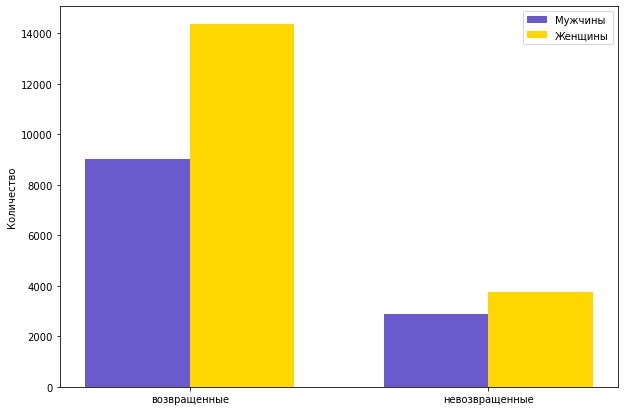

In [14]:
labels = ['возвращенные', 'невозвращенные']
men = [len(men_mon_back), len(men_mon_not_back)]
women = [len(women_mon_back), len(women_mon_not_back)]

x = np.arange(len(labels)) 
width = 0.35  


fig, ax = plt.subplots(figsize=(10,7))
rects1 = ax.bar(x - width/2, men, width, color=colors[1], label='Мужчины')
rects2 = ax.bar(x + width/2, women, width, color=colors[3], label='Женщины')

_ = ax.legend()
_ = ax.set_xticks([0, 1])
_ = ax.set_xticklabels(labels)
_ = ax.set_ylabel('Количество')

Женщины чаще берут кредиты.

#### Гипотеза о том, что гендерный состав группы людей вернувших и не вернувших кредит отличается.

#### Построим доверительные интервалы для доли вернувших, не вернувших и для их разности.

In [15]:
men_mon_back = credit_story[credit_story.SEX == 1][credit_story.default == 0]
women_mon_back = credit_story[credit_story.SEX == 2][credit_story.default == 0]
men_mon_not_back = credit_story[credit_story.SEX == 1][credit_story.default == 1]
women_mon_not_back = credit_story[credit_story.SEX == 2][credit_story.default == 1]

<ipython-input-15-03eaf3ba954f>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  men_mon_back = credit_story[credit_story.SEX == 1][credit_story.default == 0]
<ipython-input-15-03eaf3ba954f>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  women_mon_back = credit_story[credit_story.SEX == 2][credit_story.default == 0]
<ipython-input-15-03eaf3ba954f>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  men_mon_not_back = credit_story[credit_story.SEX == 1][credit_story.default == 1]
<ipython-input-15-03eaf3ba954f>:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  women_mon_not_back = credit_story[credit_story.SEX == 2][credit_story.default == 1]


In [16]:
m_to_w_0 = men_mon_back.shape[0] / \
    credit_story.SEX[credit_story.default == 0].values.shape[0]
m_to_w_1 = men_mon_not_back.shape[0] / \
    credit_story.SEX[credit_story.default == 1].values.shape[0]
print('Proportions of men for default = 0: %.4f' % m_to_w_0)
print('Proportions of men for default = 1: %.4f' % m_to_w_1)

Proportions of men for default = 0: 0.3859
Proportions of men for default = 1: 0.4329


Воспользуемя доверительным интервалом на основе нормального распределения.

In [17]:
sex_0 = credit_story.SEX.loc[credit_story.default == 0].values
sex_1 = credit_story.SEX.loc[credit_story.default == 1].values

In [18]:
conf_int_0 = proportion_confint(np.where(sex_0 == 1)[0].shape[0], sex_0.shape[0])
conf_int_1 = proportion_confint(np.where(sex_1 == 1)[0].shape[0], sex_1.shape[0])
print('CI for prop. of men or default = 0: [%.4f, %.4f]' % conf_int_0)
print('CI for prop. of men or default = 1: [%.4f, %.4f]' % conf_int_1)

CI for prop. of men or default = 0: [0.3796, 0.3921]
CI for prop. of men or default = 1: [0.4210, 0.4449]


Как видно из интервальных оценок, сами интервалы не пересекаются, следовательно гендерный состав различается.

### 3. Образование (EDUCATION).

EDUCATION: образование (0 = доктор, 1 = магистр; 2 = бакалавр; 3 = выпускник школы; 4 = начальное образование; 5 = прочее; 6 = нет данных)

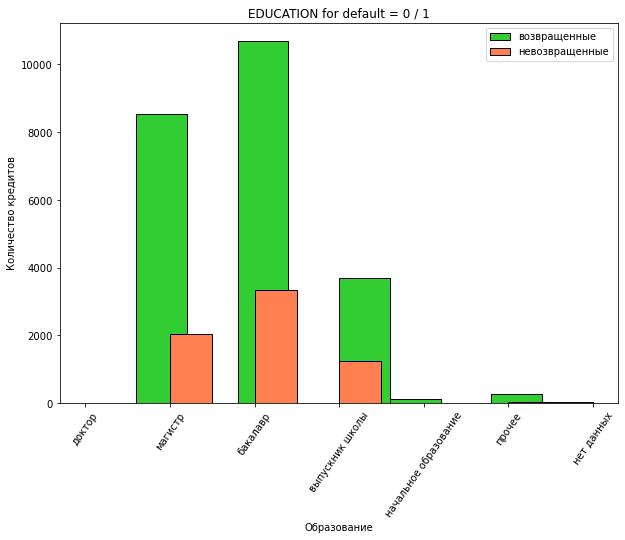

In [19]:
# histogram of EDUCATION distribution

labels = ['доктор', 'магистр', 'бакалавр', 'выпускник школы',
          'начальное образование', 'прочее', 'нет данных']
fig, ax = plt.subplots(figsize=(10, 7))
edu_0 = credit_story.loc[credit_story.default == 0, 'EDUCATION'].values
edu_1 = credit_story.loc[credit_story.default == 1, 'EDUCATION'].values

_ = ax.set_xticks(np.arange(len(labels)))
_ = ax.set_xticklabels(labels)


_ = plt.xlabel("Образование")
_ = plt.ylabel("Количество кредитов")
_ = plt.title('EDUCATION for default = 0 / 1')
_ = plt.hist(edu_0,
             edgecolor='k', color=colors[0], label='возвращенные')
_ = plt.hist(edu_1,
             edgecolor='k', color=colors[4], label='невозвращенные')
_ = plt.legend()
_ = plt.xticks(rotation=55)

В основном берут кредиты магистры и бакалавры. Принципиальная разница между распределниями тех, кто вернул, и тех, кто нет, не наблюдается.

#### Гипотеза о влиянии образования на возвращение кредита.

Построим график вероятностей возврата кредитов.

In [80]:
edu = credit_story.EDUCATION
labels = np.unique(edu)
edu_0 = credit_story.EDUCATION[credit_story.default == 0]
edu_1 = credit_story.EDUCATION[credit_story.default == 1]
edu_prop = np.empty(len(np.unique(edu_0)))
for i in labels:
    edu_prop[i] = (len(edu_0[edu_0.values == i]) / len(edu[edu.values == i]))

In [81]:
data = pd.DataFrame(data=edu_prop)

In [82]:
for ed_val, prop in enumerate(edu_prop):
    print('Prob of def=0 for education=%d: %.2f' % (ed_val, prop))

Prop. of def.=0 for education=0: 1.00
Prop. of def.=0 for education=1: 0.81
Prop. of def.=0 for education=2: 0.76
Prop. of def.=0 for education=3: 0.75
Prop. of def.=0 for education=4: 0.94
Prop. of def.=0 for education=5: 0.94
Prop. of def.=0 for education=6: 0.84


No handles with labels found to put in legend.


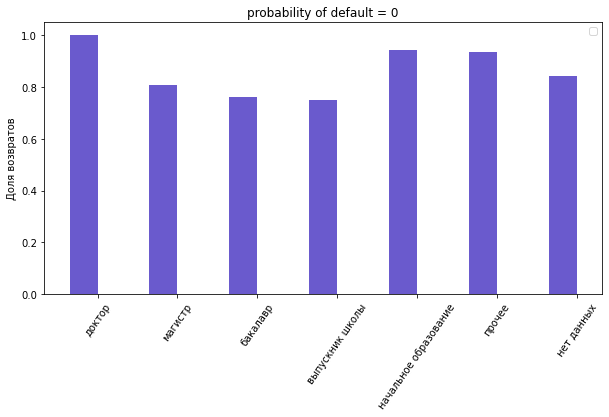

In [103]:
labels = ['доктор', 'магистр', 'бакалавр', 'выпускник школы',
          'начальное образование', 'прочее', 'нет данных']
width = 0.35
fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, edu_prop, width, color=colors[1])
_ = ax.set_xticks(np.arange(len(labels)))
_ = ax.set_xticklabels(labels)

_ = ax.set_ylabel('Доля возвратов')
_ = plt.title('probability of default = 0')
_ = ax.legend()
_ = plt.xticks(rotation=55)

Исходя из графика видно, что распределние не является равномерным, следовательно, образование влияет на то, вернёт ли человек долг. Реже всего возвращают долги категории 2 и 3 (бакалавры и выпускники школ). Возвращают практически все долги только люди с докторской степенью.

#### Произведём строгую проверку на соответствие данного распределения равномерному с помощью критерия согласия Пирсона хи-квадрат.

* H0: рассматривая величина имеет равномерное распределение
* H1: H0 не верна

In [99]:
# Таблица сопряженности
table_sopr = []
table_chi2 = []

mon_back = credit_story[credit_story['default'] == 0]
mon_no_back = credit_story[credit_story['default'] == 1]
for i in x:
    
    ret = len(mon_back[mon_back['EDUCATION'] == i])
    noret = len(mon_no_back[mon_no_back['EDUCATION'] == i])
    all_ = ret + noret
    
    table_sopr.append((i, ret, noret))
    table_chi2.append([ret, noret])
    
table_sopr

[(0, 14, 0),
 (1, 8549, 2036),
 (2, 10700, 3330),
 (3, 3680, 1237),
 (4, 116, 7),
 (5, 262, 18),
 (6, 43, 8)]

Для проверки гипотезы применим критерий Хи-квадрат. Это можно сделать, т.к. размер выборки больше 40, и ячейек в таблице со значением меньше 5 не более, чем в 20% ячеек (такая ячейка одна, у "докторской степени" кол-во невозвратов равно 0).

In [100]:
chi2, p, dof, expected = stats.chi2_contingency(table_chi2)
print("p-value = ", p)

p-value =  1.2332626245415605e-32


Гипотеза о том, что уровень образования не влияет на возврат долга - опровергается.

### 4. Семейное положение (MARRIAGE).

MARRIAGE: (0 = отказываюсь отвечать; 1 = замужем/женат; 2 = холост; 3 = нет данных).

In [101]:
mar_money_back = credit_story.MARRIAGE[credit_story.default == 0]
mar_money_not_back = credit_story.MARRIAGE[credit_story.default == 1]

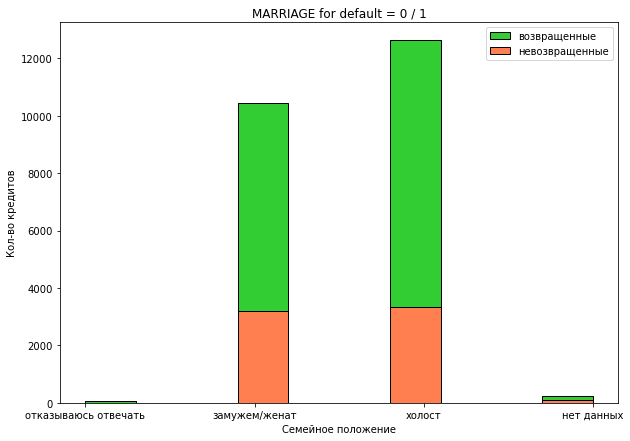

In [108]:
fig, ax = plt.subplots(figsize=(10, 7))
labels = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'нет данных']

_ = plt.xlabel("Семейное положение")
_ = plt.ylabel("Кол-во кредитов")
_ = plt.title('MARRIAGE for default = 0 / 1')
_ = plt.hist(mar_money_back, edgecolor='k',
             color=colors[0], label='возвращенные')
_ = plt.hist(mar_money_not_back, edgecolor='k',
             color=colors[4], label='невозвращенные')
_ = ax.set_xticks(np.arange(len(labels)))
_ = ax.set_xticklabels(labels)
_ = plt.legend()

Доли невозвратов среди женатых и холостых людей различается примерно на 10%.

#### Проверим, как связан семейный статус с индикатором дефолта.

In [113]:
# Таблица сопряженности
table_sopr = []
table_chi2 = []
labels = ['отказываюсь отвечать', 'замужем/женат', 'холост', 'Нет данных']
x = np.arange(len(labels))
for i in x:

    ret = len(mon_back[mon_back['MARRIAGE'] == i])
    noret = len(mon_no_back[mon_no_back['MARRIAGE'] == i])
    all_ = ret + noret

    table_sopr.append((i, ret, noret))
    table_chi2.append([ret, noret])

table_sopr

[(0, 49, 5), (1, 10453, 3206), (2, 12623, 3341), (3, 239, 84)]

In [114]:
chi2, p, dof, expected = stats.chi2_contingency(table_chi2)
print("p-value = ", p)

p-value =  8.825862457577375e-08


In [119]:
#samples of MARRIAGE for default = 0/1
mar = credit_story.MARRIAGE
mar_0 = credit_story.MARRIAGE.loc[credit_story.default == 0]
mar_1 = credit_story.MARRIAGE.loc[credit_story.default == 1]

print('Value counts for marriage:')
mar.value_counts()

Value counts for marriage:


2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

Составим таблицу сопряжённости для признаков default и MARRIAGE.

In [120]:
conf_table = np.empty( (len(mar.value_counts()), 2) )
for i in range(len(mar.value_counts())):
    conf_table[i, 0] = len(mar_0.loc[mar_0 == i])
    conf_table[i, 1] = len(mar_1.loc[mar_1 == i])
conf_table

array([[4.9000e+01, 5.0000e+00],
       [1.0453e+04, 3.2060e+03],
       [1.2623e+04, 3.3410e+03],
       [2.3900e+02, 8.4000e+01]])

Вычислим коэффициент V Крамера.

In [121]:
def cramers_stat(confusion_matrix):
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum()
    return np.sqrt(chi2 / (n*(min(confusion_matrix.shape)-1)))

In [122]:
print('V Cramer stat value: %.4f' % cramers_stat(conf_table))

V Cramer stat value: 0.0345


Коэффициент Крамера принимает значение, близкое к нулю, когда взаимосвязь отсутствует.

### 5. Возраст (AGE).

In [123]:
age_money_back = credit_story.AGE[credit_story.default == 0]
age_money_not_back = credit_story.AGE[credit_story.default == 1]

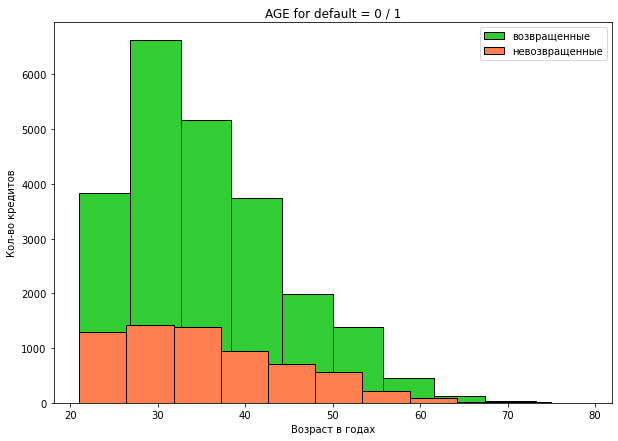

In [125]:
fig, ax = plt.subplots(figsize=(10, 7))

_ = plt.xlabel("Возраст в годах")
_ = plt.ylabel("Кол-во кредитов")
_ = plt.title('AGE for default = 0 / 1')
_ = plt.hist(age_money_back, edgecolor='k',
             color=colors[0], label='возвращенные')
_ = plt.hist(age_money_not_back, edgecolor='k',
             color=colors[4], label='невозвращенные')

_ = plt.legend()

Люди, моложе 25, склонны реже остальных возвращать кредиты.

#### Гипотеза о равенстве распределений.

Для проверки гипотезы подойдёт перестановочный критерий для независимых выборок.

* H0: распределения выборок полностью равны
* H1: распределения выборок отличаются на величину сдвига

In [129]:
stats.mannwhitneyu(age_money_back, age_money_not_back)

MannwhitneyuResult(statistic=76966879.5, pvalue=0.1862517717449308)

P-value получается довольно маленьким и нулевая гипотеза отвергается на уровне значимости 0.05.